In [1]:
# %matplotlib widget

In [2]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials,select_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
import pca_tools
from scipy import stats
from ephysvibe.task import task_constants
seed=2024

### Define functions

In [3]:
def to_python_hdf5(dat:List, save_path: Path):
    """Save data in hdf5 format."""
    # save the data
    with h5py.File(save_path, "w") as f:
        for i_d in range(len(dat)):
            group = f.create_group(str(i_d))

            for key, value in zip(dat[i_d].keys(), dat[i_d].values()):
                group.create_dataset(key, np.array(value).shape, data=value)
    f.close()

In [4]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [5]:
def z_score(x):
    mu = np.mean(x,axis=0)
    sigma = np.std(x,axis=0)
    sigma0=sigma
    sigma0[sigma == 0] = 1 
    zs_x = (x-mu) / sigma0
    return zs_x

In [6]:
def get_fr_samples(sp,sample_id,start,end,samples,min_trials):
    # parameters

    # Check fr
    ms_fr=np.nanmean(sp[:,start:end])*1000>5
    if not ms_fr:
        return None
    # Average spikes
    #avg_sample = firing_rate.moving_average(sp, win=win, step = 1)
    fr_samples = []
    for s_id in samples:
        sample_fr = sp[np.where(sample_id==s_id,True,False),start:end]
        # Check number of trials
        if sample_fr.shape[0]< min_trials:
            return None
        fr_samples.append(np.mean(sample_fr,axis=0))
    return fr_samples


In [7]:
def get_neuron_sample_fr(path,time_before,start,end,min_trials):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    if np.sum(mask)<20:
        return {'fr':None}
    sample_id = neu_data.sample_id[mask]
    fr_samples = get_fr_samples(sp_sample_on,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51],min_trials=min_trials)
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

In [8]:
def check_triasl(sp,idx_start,idx_end):
    sig_trials = np.sum(sp,axis=1)>0
    return sig_trials

In [9]:
def select_alltrials(neu_data,select_block,code,time_before,error_type=0):
    sp_sample_on, mask_sample = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= error_type,
    )
    sp_test1_on, mask_test1 = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = time_before+400,
        error_type= error_type,
    )
    if np.any(mask_sample != mask_test1):
        return "error"
    return sp_sample_on,sp_test1_on,mask_sample,mask_test1

In [10]:
def get_neuron_sample_test1_fr(path,time_before,start,end,end_test,n_test,min_trials,nonmatch=True,win=50):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on,sp_test1_on,mask_sample,mask_test1 = select_alltrials(neu_data,select_block,code,time_before,error_type=0)

    mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
    mask_neu = neu_data.sample_id[mask_test1]==0
    max_test = neu_data.test_stimuli[mask_test1].shape[1]
    mask_ntest = (max_test-np.sum(np.isnan(neu_data.test_stimuli[mask_test1]),axis=1))>(n_test-1)

    if nonmatch:
        mask_match_neu = np.logical_or(mask_ntest,mask_neu)
    else:
        mask_match_neu = np.logical_or(mask_match,mask_neu)
    if np.sum(mask_match_neu)<20:
        return {'fr':None}
    
    avg_sample_on = firing_rate.moving_average(sp_sample_on[mask_match_neu], win=win, step = 1)[:,:time_before+450+400]
    avg_test1_on = firing_rate.moving_average(sp_test1_on[mask_match_neu], win=win, step = 1)[:,time_before:time_before+end_test+400]
    sp = np.concatenate((avg_sample_on,avg_test1_on),axis=1)[:,idx_start:idx_end]
    # Check fr
    ms_fr = np.nanmean(sp)*1000>5
    if not ms_fr:
        return {'fr':None}
    
    sample_id = neu_data.sample_id[mask_test1][mask_match_neu]
    samples=[0,11,15,55,51]
    for s_id in samples:
        sample_fr = sp[np.where(sample_id==s_id,True,False)]
        # Check number of trials
        if sample_fr.shape[0]< min_trials:
            return {'fr':None}
    
    
    fr_samples = select_trials.get_sp_by_sample(sp,sample_id,samples=samples)

    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

### Read data

In [176]:
greyscale=['#000000','#0F0F0F','#3D3D3D','#6B6B6B','#7A7A7A','#999999','#C7C7C7','#D6D6D6']
colors_g=['#001755','#002B95','#0036B3','#1A54D8','#3566DF','#4F79E5','#84A0F0','#9EB4F5']

In [95]:
# Load data
n_test=1
min_trials=10
nonmatch=True
time_before=500
start=-200
end_test = n_test*450+200
end=450+400+400+end_test
win=50
# Define epochs
part1 = 200+450+400
test1_st = part1+400
test2_st = test1_st+450
test3_st = test2_st+450
test4_st = test3_st+450
test5_st = test4_st+450
idx_f = np.arange(0,200,2)
idx_s = np.arange(200,200+450,2)
idx_d1 = np.arange(200+450,part1,2)
idx_d2 = np.arange(part1,test1_st,2)
idx_t1 = np.arange(test1_st,test2_st,2)
idx_t2 = np.arange(test2_st,test3_st,2)
idx_t3 = np.arange(test3_st,test4_st,2)
idx_t4 = np.arange(test4_st,test5_st,2)
idx_aftert = np.arange(test2_st,end-start,2)

area='lip'
subject='Riesling'

In [ ]:
# part 1 
t_epochs1 = {'fixation':idx_f,'sample':idx_s,'delay':idx_d1}#,'test3':idx_t3,'test4':idx_t4 'test2':idx_t2,
colors1 = {'epochs':{'fixation':colors_g[0],'sample':colors_g[1],'delay':colors_g[1]}}
colors_neu1 = {'epochs':{'fixation':greyscale[0],'sample':greyscale[1],'delay':greyscale[1]}}#
# part 2 
t_epochs2 = {'delay':idx_d2,'test1':idx_t1,'test off':idx_aftert}#,'test3':idx_t3,'test4':idx_t4 'test2':idx_t2,
colors2 = {'epochs':{'delay':colors_g[6],'test1':colors_g[6],'test2':colors_g[6],'test3':colors_g[6],'test4':colors_g[6],'test off':colors_g[-1]}}
colors_neu2 = {'epochs':{'delay':greyscale[5],'test1':greyscale[5],'test2':greyscale[5],'test3':greyscale[5],'test4':greyscale[5],'test off':greyscale[7]}}#

In [96]:
end-start

2100

In [214]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

neu_path = basepath+'/session_struct/'+area+'/neurons/*neu.h5'
all_path_list = glob.glob(neu_path)

all_sessions = []
for ipath in all_path_list:
    all_sessions.append(ipath.replace("\\", "/").split("/")[-1][:19])
all_sessions = np.unique(all_sessions)
session = str(all_sessions[7])
print(session)
mask = []
for path in all_path_list:
    mask.append(
        session
        == path.replace("\\", "/").rsplit("/")[-1].rsplit("_" + subject)[0]
    )
path_list = np.array(all_path_list)[np.array(mask)]

2022-12-16_10-30-59


In [215]:
data = Parallel(n_jobs = -1)(delayed(get_neuron_sample_test1_fr)(path,time_before,start,end,end_test,n_test,min_trials,nonmatch,win) for path in tqdm(path_list))

100%|██████████| 16/16 [00:00<00:00, 4364.52it/s]


In [216]:
if nonmatch:
    pname_match='_wnonmatch_'
else:
    pname_match='_match_'

In [217]:
s0,s11,s15,s51,s55 = [],[],[],[],[]
for asc in data:
    fr = asc["fr"]
    if fr is not None:

        s0.append( fr['0'] )
        s11.append(fr['11'])
        s15.append(fr['15'])
        s51.append(fr['51'])
        s55.append(fr['55'])
neurons_fr=[{'0':s0,'11':s11,'15':s15,'51':s51,'55':s55}]


basepath = './'#'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/pca/data/'+area +'/'
to_python_hdf5(dat=neurons_fr, save_path=basepath+area+'_trials_win'+str(win)+'_test'+str(n_test)+pname_match+'min'+str(min_trials)+'tr_pca.h5')

In [218]:
len(s55)

7

In [219]:
neurons_fr_read=from_python_hdf5(load_path=basepath+area+'_trials_win'+str(win)+'_test'+str(n_test)+pname_match+'min'+str(min_trials)+'tr_pca.h5')
neurons_fr = neurons_fr_read[0]

In [220]:
mean11=np.mean(neurons_fr['11'],axis=1)
mean15=np.mean(neurons_fr['15'],axis=1)
mean51=np.mean(neurons_fr['51'],axis=1)
mean55=np.mean(neurons_fr['55'],axis=1)
mean0=np.mean(neurons_fr['0'],axis=1)

lip: 1 components to explain 80% of the variance


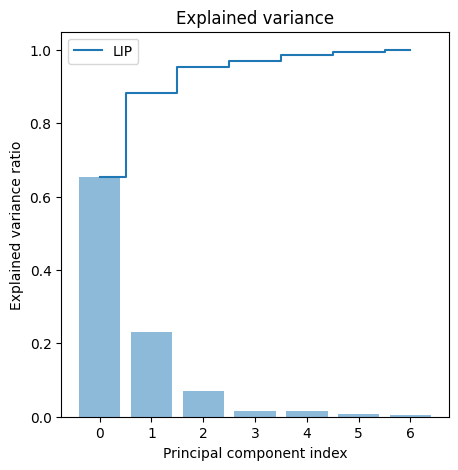

In [221]:
n_comp=len(neurons_fr['11'])
model,pc_s = pca_tools.compute_pca(np.concatenate((mean0,mean11,mean15,mean51,mean55),axis=1),n_comp=n_comp)
pca_tools.plot_explained_var(model,figsize=(5,5),area=area)

In [223]:
pc_s.shape

(7, 10500)

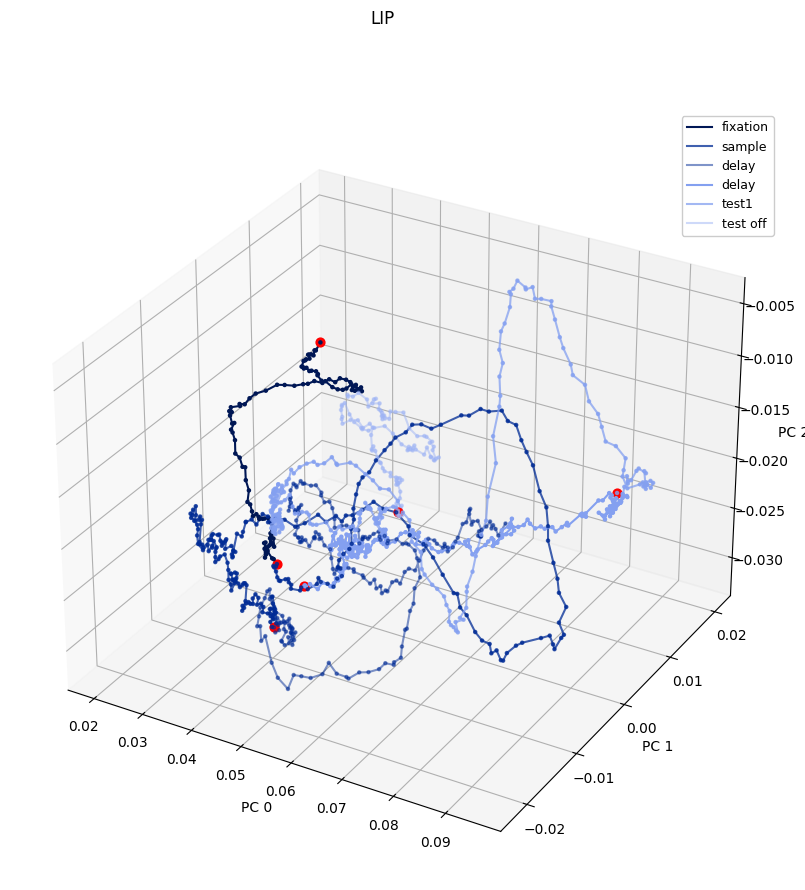

In [225]:

fig, ax = plt.subplots(figsize=(10,10), sharey=True, sharex=True, subplot_kw={"projection": "3d"})
reshape_pc_s= pc_s.reshape(n_comp,-1,end-start)
mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
pca_tools.plot_pc_3d(mean_pc_s,colors1,t_epochs1,area,sample_flag = False,fig=fig, ax=ax)
pca_tools.plot_pc_3d(mean_pc_s,colors2,t_epochs2,area,sample_flag = False,fig=fig, ax=ax)

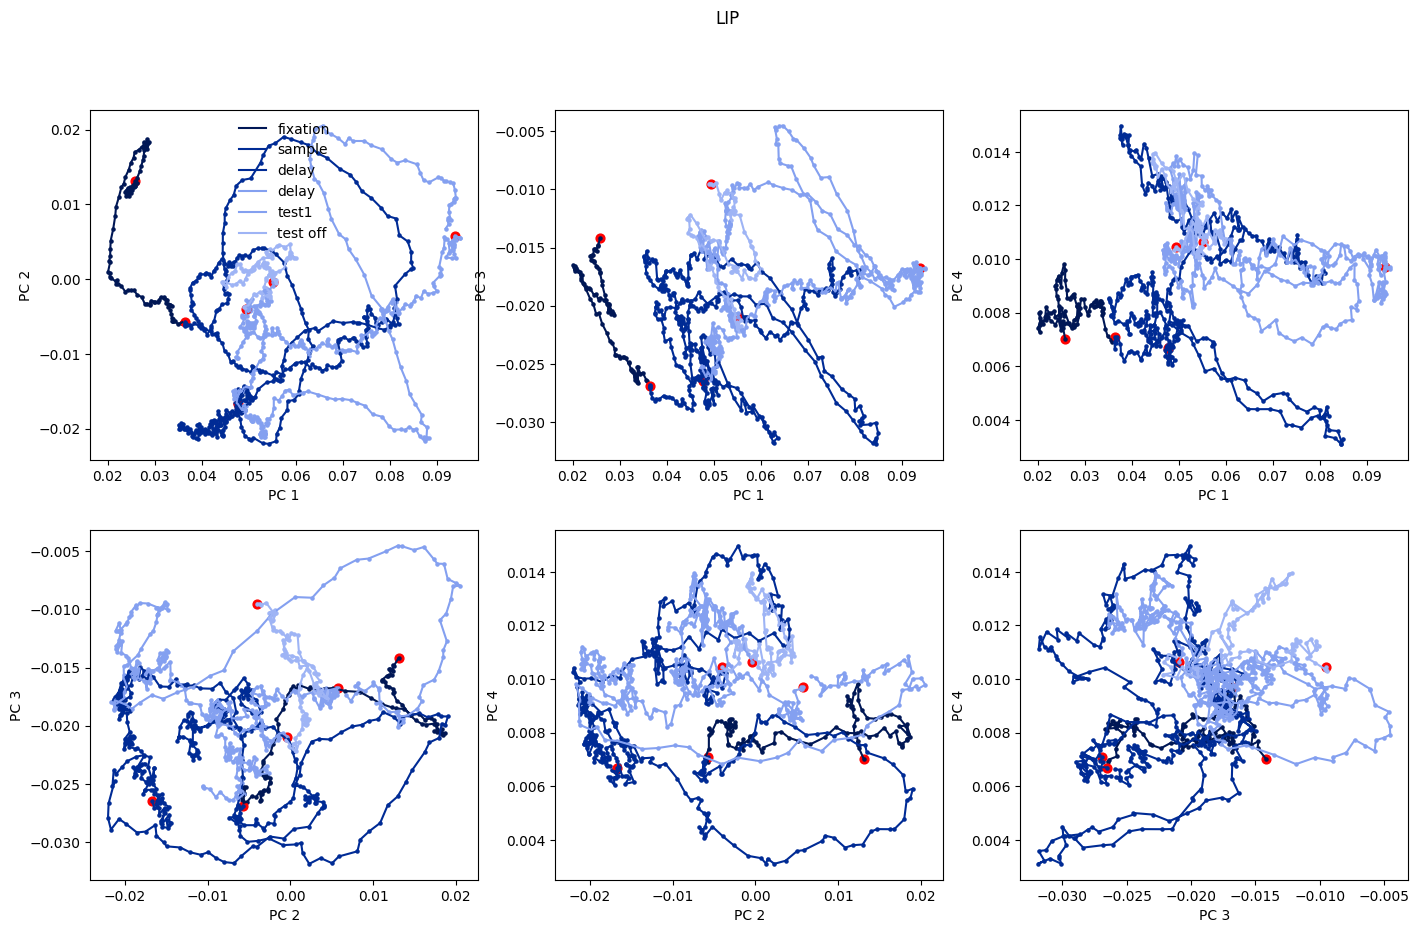

In [226]:
mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
fig, ax = plt.subplots(2, 3, figsize=(17,10))
pca_tools.plot_pc(mean_pc_s,colors1,t_epochs1,area,sample_flag = False,fig=fig, ax=ax,idot=0)
pca_tools.plot_pc(mean_pc_s,colors2,t_epochs2,area,sample_flag = False,fig=fig, ax=ax,idot=-1)

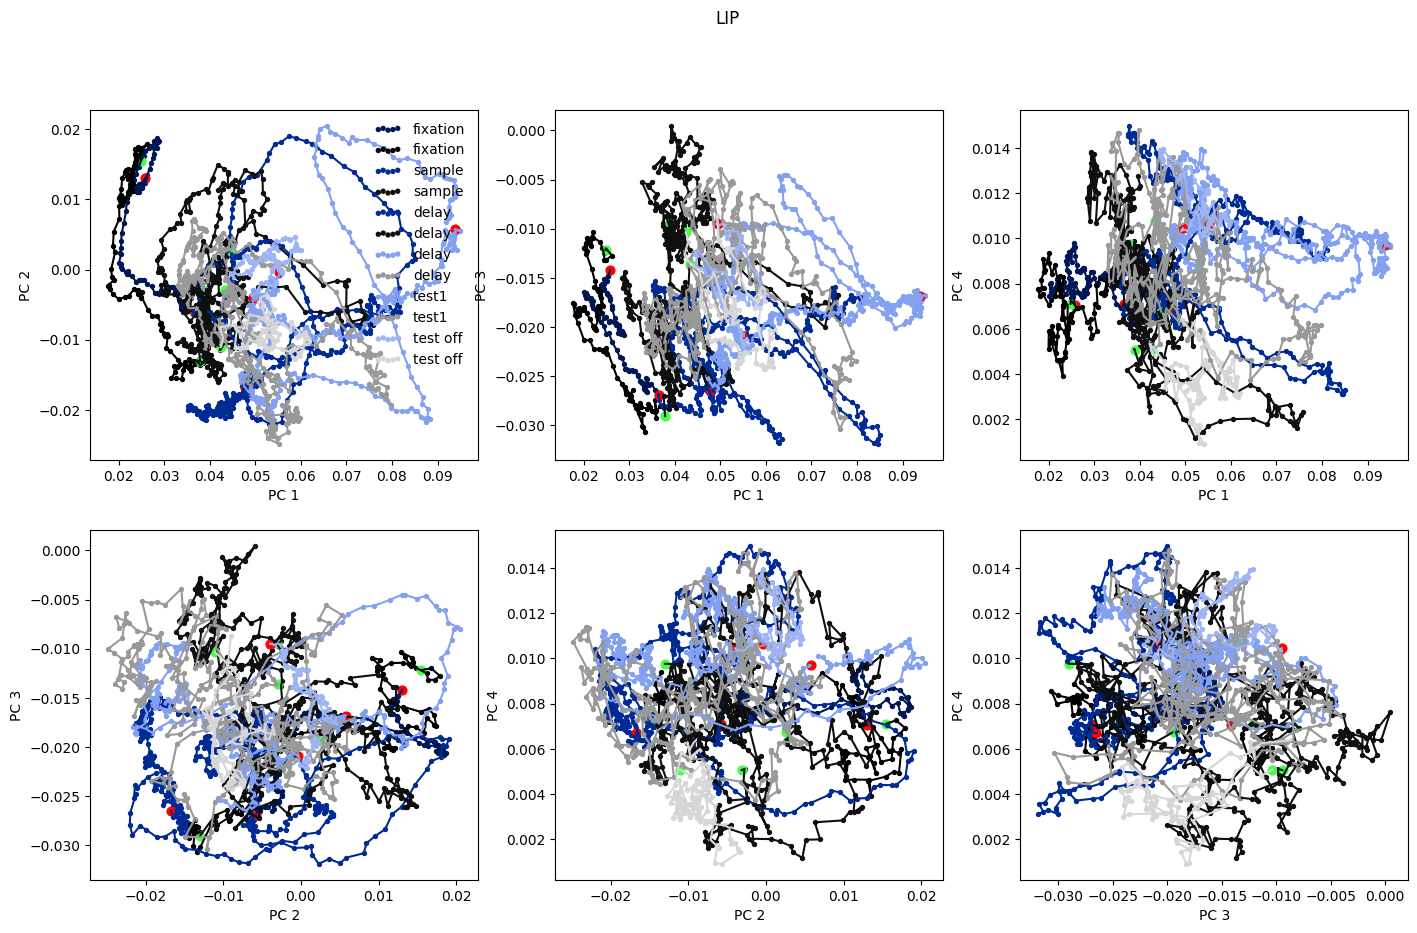

In [227]:
mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
fig, ax = plt.subplots(2, 3, figsize=(17,10))
pca_tools.plot_pc_neu(mean_pc_s,reshape_pc_s[:,0],colors1,colors_neu1,t_epochs1,area,fig=fig, ax=ax ,idot=0)
pca_tools.plot_pc_neu(mean_pc_s,reshape_pc_s[:,0],colors2,colors_neu2,t_epochs2,area,fig=fig , ax=ax,idot=-1)

In [228]:
samples={
    "0": 0,
    "11": 1,
    "15": 2,
    "55": 3,
    "51": 4,
    
}

In [229]:
part1=200+450+400

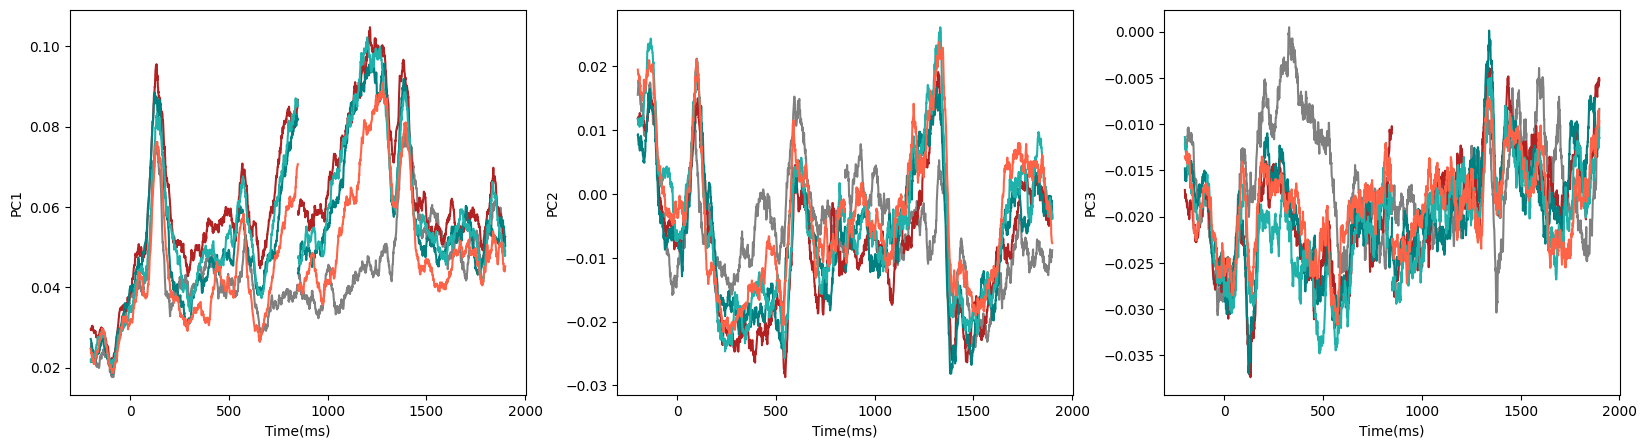

In [230]:
f,ax=plt.subplots(1,3,figsize=(20,5))
for i_sample in samples.keys():
    
    ax[0].plot(range(start,end)[:part1],reshape_pc_s[0,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
    #ax[0].vlines(850,0,0.5)
    ax[1].plot(range(start,end)[:part1],reshape_pc_s[1,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
    ax[2].plot(range(start,end)[:part1],reshape_pc_s[2,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)

    ax[0].plot(range(start,end)[part1:],reshape_pc_s[0,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
    #ax[0].vlines(850,0,0.5)
    ax[1].plot(range(start,end)[part1:],reshape_pc_s[1,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
    ax[2].plot(range(start,end)[part1:],reshape_pc_s[2,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample],label=i_sample)

    ax[0].set(xlabel='Time(ms)',ylabel='PC1')
    ax[1].set(xlabel='Time(ms)',ylabel='PC2')
    ax[2].set(xlabel='Time(ms)',ylabel='PC3')